In [24]:
!pip install yfinance pandas numpy matplotlib ccxt
!pip install seaborn --upgrade

In [45]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jimitnahar","key":"173bbf0bafdc14aecb104474896d24f7"}'}

In [46]:
# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move the uploaded kaggle.json file to the correct location
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


In [47]:
# Install Kaggle CLI
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d mczielinski/bitcoin-historical-data

# Unzip the dataset
!unzip bitcoin-historical-data.zip -d bitcoin_data


Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
  0% 0.00/95.4M [00:00<?, ?B/s]
100% 95.4M/95.4M [00:00<00:00, 1.23GB/s]
Archive:  bitcoin-historical-data.zip
  inflating: bitcoin_data/btcusd_1-min_data.csv  


In [60]:
import pandas as pd
import numpy as np

# Load BTC data
df = pd.read_csv("/content/bitcoin_data/btcusd_1-min_data.csv")

# Convert timestamp column to datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')

# Filter date range — for example, from Jan 1, 2018 to March 1, 2018
start_date = "2018-01-01"
end_date = "2018-05-01"

# Filter the DataFrame
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Preview result
print(df.head())

# Set datetime as index
df.set_index('date', inplace=True)

# Rename 'Close' to 'BTC' and keep only the needed column
df = df[['Close']].rename(columns={'Close': 'BTC'})

# Drop rows with missing or zero prices
df = df[df['BTC'] > 0]


            Timestamp      Open      High       Low     Close     Volume  \
3155879  1.514765e+09  13840.53  13840.53  13819.04  13820.96   1.045522   
3155880  1.514765e+09  13821.05  13888.90  13821.05  13850.67  18.083867   
3155881  1.514765e+09  13888.91  13938.63  13850.01  13850.40   3.553685   
3155882  1.514765e+09  13850.40  13933.94  13850.40  13894.25   0.894357   
3155883  1.514765e+09  13894.26  13978.24  13879.83  13880.45  11.214208   

                       date  
3155879 2018-01-01 00:00:00  
3155880 2018-01-01 00:01:00  
3155881 2018-01-01 00:02:00  
3155882 2018-01-01 00:03:00  
3155883 2018-01-01 00:04:00  


In [61]:
# Simulated ETH prices based on BTC, slightly offset + some noise
df['ETH'] = df['BTC'].shift(-1) * np.random.normal(loc=1.01, scale=0.005, size=len(df))

# Drop NaNs from shift
df.dropna(inplace=True)

# Final dataframe that works like yfinance
data = df[['BTC', 'ETH']]
data.head()


In [41]:
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

exchange = ccxt.kucoin({
    'enableRateLimit': True
})

symbols = ['BTC/USDT', 'ETH/USDT']
timeframe = '1m'
limit = 1000
days_back = 30

def fetch_1m(symbol, days_back):
    since = exchange.parse8601((datetime.utcnow() - timedelta(days=days_back)).isoformat())
    all_data = []
    print(f"🔄 Fetching {symbol} 1m data for last {days_back} days…")
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
        df.set_index('Timestamp', inplace=True)
        all_data.append(df)
        since = ohlcv[-1][0] + 60_000  # Move to next minute
        if df.index[-1] >= datetime.utcnow() - timedelta(minutes=2):
            break
        time.sleep(0.5)
    if all_data:
        full = pd.concat(all_data)
        full = full[~full.index.duplicated(keep='first')]
        return full[['Open', 'High', 'Low', 'Close', 'Volume']]
    else:
        return pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Fetch BTC and ETH
btc = fetch_1m('BTC/USDT', days_back)
eth = fetch_1m('ETH/USDT', days_back)

# Preview to confirm format
print("BTC sample:")
display(btc.head())
print("ETH sample:")
display(eth.head())

# Combine BTC and ETH closing prices into one DataFrame
data = pd.DataFrame({
    'BTC': btc['Close'],
    'ETH': eth['Close']
}).dropna()


🔄 Fetching BTC/USDT 1m data for last 30 days…
🔄 Fetching ETH/USDT 1m data for last 30 days…
BTC sample:


,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-06-26 08:48:00,107784.4,107793.7,107771.3,107771.3,0.457916
2025-06-26 08:49:00,107771.2,107780.3,107765.3,107780.3,0.062871
2025-06-26 08:50:00,107780.4,107805.3,107780.4,107805.3,0.356227
2025-06-26 08:51:00,107805.2,107805.3,107776.6,107776.6,0.188184
2025-06-26 08:52:00,107776.6,107776.7,107739.6,107739.6,1.019179


ETH sample:


,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-06-26 08:49:00,2485.33,2487.50,2485.09,2487.50,35.636616
2025-06-26 08:50:00,2487.56,2487.81,2487.30,2487.30,33.020140
2025-06-26 08:51:00,2488.03,2488.20,2486.84,2486.84,51.934853
2025-06-26 08:52:00,2487.23,2487.23,2485.30,2485.84,35.677624
2025-06-26 08:53:00,2486.16,2487.46,2486.16,2487.23,50.898120


In [63]:
# Define a range of lag values to test (from -5 to 5 minutes inclusive)
lag_range = range(-5, 6)

# Store the lag values and their corresponding correlations
lagged_correlations = {}

# For each lag value, calculate the correlation
for lag in lag_range:
    if lag > 0:
        # Lagging BTC prices relative to ETH
        correlation = data['ETH'].corr(data['BTC'].shift(lag))
    elif lag < 0:
        # Lagging ETH prices relative to BTC (shift ETH by -lag to move it forward)
        correlation = data['BTC'].corr(data['ETH'].shift(-lag))
    else:
        # No lag
        correlation = data['BTC'].corr(data['ETH'])

    lagged_correlations[lag] = correlation

# Convert the results to a pandas Series for easier analysis
lag_correlation_series = pd.Series(lagged_correlations)

# Identify the lag with the highest absolute correlation.
most_correlated_lag = lag_correlation_series.abs().idxmax()
highest_correlation_value = lag_correlation_series[most_correlated_lag]

# Print the lagged correlations
print("Lagged Correlations (1-minute intervals):")
display(lag_correlation_series)

# Print the lag with the highest absolute correlation and its value
print(f"\nLag with the highest absolute correlation: {most_correlated_lag} minutes")
print(f"Highest absolute correlation value: {abs(highest_correlation_value):.4f}")
print(f"Correlation value at most correlated lag: {highest_correlation_value:.4f}")

Lagged Correlations (1-minute intervals):


,0
-5,0.999638
-4,0.999668
-3,0.999699
-2,0.999730
-1,0.999767
0,0.999730
1,0.999698
2,0.999668
3,0.999637
4,0.999607



Lag with the highest absolute correlation: -1 minutes
Highest absolute correlation value: 0.9998
Correlation value at most correlated lag: 0.9998


In [64]:
# Determine the optimal lag value from the previous step (not directly used for entry signal anymore, but kept for potential future use or reference)
optimal_lag = most_correlated_lag
print(f"Optimal Lag for 1-minute data (from previous analysis): {optimal_lag} minutes")

# Define the window for checking BTC bias (30 minutes)
btc_bias_window_minutes = 30

# Calculate the price change of BTC over the last 30 minutes
data['BTC_price_change_30min'] = data['BTC'].diff(periods=btc_bias_window_minutes)

# Initialize signal, position, and entry_price/time columns
data['signal'] = 0 # 0: no position, 1: long, -1: short
data['position'] = 0 # 0: flat, 1: long, -1: short
data['entry_price'] = np.nan # To store the entry price
data['entry_time'] = pd.NaT # To store the entry time (using pandas Not a Time)

# Define the trading duration for open positions (1 minute, as per next candle logic)
trading_duration_intervals = 1 # 1 interval = 1 minute

# Implement the trading logic by iterating through the data
for i in range(1, len(data)):
    # If not currently in a position
    if data['position'].iloc[i-1] == 0:
        # Check for entry signals based on BTC price change over the last 30 minutes
        long_entry_condition = data['BTC_price_change_30min'].iloc[i] > 0
        short_entry_condition = data['BTC_price_change_30min'].iloc[i] < 0

        # If long entry signal met
        if long_entry_condition:
            data.loc[data.index[i], 'signal'] = 1
            data.loc[data.index[i], 'position'] = 1
            data.loc[data.index[i], 'entry_price'] = data['ETH'].iloc[i]
            data.loc[data.index[i], 'entry_time'] = data.index[i]

        # If short entry signal met
        elif short_entry_condition:
            data.loc[data.index[i], 'signal'] = -1
            data.loc[data.index[i], 'position'] = -1
            data.loc[data.index[i], 'entry_price'] = data['ETH'].iloc[i]
            data.loc[data.index[i], 'entry_time'] = data.index[i]

        else:
            # No signal, maintain flat position
            data.loc[data.index[i], 'position'] = 0
            data.loc[data.index[i], 'entry_price'] = np.nan
            data.loc[data.index[i], 'entry_time'] = pd.NaT


    # If currently in a position
    else:
        # Carry forward entry price and time from the previous step
        data.loc[data.index[i], 'entry_price'] = data['entry_price'].iloc[i-1]
        data.loc[data.index[i], 'entry_time'] = data['entry_time'].iloc[i-1]
        current_position = data['position'].iloc[i-1]

        # Check if trading duration has passed (exit on the next candle)
        # The time difference between consecutive rows in 1-minute data is 1 minute (or slightly more due to missing data)
        # We exit if the current index is different from the entry index + trading_duration_intervals
        if (data.index[i] - data['entry_time'].iloc[i]).total_seconds() / 60 >= trading_duration_intervals:
             # Exit the position
            data.loc[data.index[i], 'signal'] = -current_position # Opposite signal to exit
            data.loc[data.index[i], 'position'] = 0
            data.loc[data.index[i], 'entry_price'] = np.nan # Reset entry price
            data.loc[data.index[i], 'entry_time'] = pd.NaT # Reset entry time
        else:
            # Maintain current position
            data.loc[data.index[i], 'position'] = current_position
            # Signal remains 0 if maintaining position


# 8. Display the tail of the data with new columns
display(data[['BTC', 'ETH', 'BTC_price_change_30min', 'signal', 'position', 'entry_price', 'entry_time']].tail())

Optimal Lag for 1-minute data (from previous analysis): -1 minutes


,BTC,ETH,BTC_price_change_30min,signal,position,entry_price,entry_time
date,,,,,,,
2018-04-30 23:55:00,9318.89,9392.077203,13.61,1,1,9392.077203,2018-04-30 23:55:00
2018-04-30 23:56:00,9316.50,9421.080087,18.18,-1,0,NaN,NaT
2018-04-30 23:57:00,9320.50,9403.352972,13.55,1,1,9403.352972,2018-04-30 23:57:00
2018-04-30 23:58:00,9329.97,9414.704133,32.85,-1,0,NaN,NaT
2018-04-30 23:59:00,9326.60,9432.573822,29.48,1,1,9432.573822,2018-04-30 23:59:00


In [65]:
# Calculate daily returns for Ethereum
data['ETH_daily_return'] = data['ETH'].pct_change()

# Calculate the strategy's daily returns based on position
# The daily return for the strategy at time `i` is the ETH return at time `i`
# multiplied by the position held *during* the period from `i-1` to `i`.
# This position is represented by `data['position'].iloc[i-1]` in the loop logic.
# So, we can calculate strategy return by multiplying ETH return by the *shifted* position.
data['strategy_daily_return'] = data['ETH_daily_return'] * data['position'].shift(1)

# Calculate cumulative returns
data['ETH_cumulative_return'] = (1 + data['ETH_daily_return']).cumprod() - 1
data['strategy_cumulative_return'] = (1 + data['strategy_daily_return']).cumprod() - 1

# Display the tail of the data with return columns
display(data[['ETH_daily_return', 'strategy_daily_return', 'ETH_cumulative_return', 'strategy_cumulative_return']].tail())

,ETH_daily_return,strategy_daily_return,ETH_cumulative_return,strategy_cumulative_return
date,,,,
2018-04-30 23:55:00,-0.009473,-0.000000,-0.324751,-0.657388
2018-04-30 23:56:00,0.003088,0.003088,-0.322666,-0.656330
2018-04-30 23:57:00,-0.001882,-0.000000,-0.323940,-0.656330
2018-04-30 23:58:00,0.001207,0.001207,-0.323124,-0.655915
2018-04-30 23:59:00,0.001898,0.000000,-0.321839,-0.655915


Performance Metrics (1-minute data):
  Total Return (Strategy): -0.6559
  Total Return (Benchmark): -0.3218
  Annualized Return (Strategy): -0.9610
  Annualized Return (Benchmark): -0.6931
  Annualized Volatility (Strategy): 3.7287
  Annualized Volatility (Benchmark): 5.2794
  Sharpe Ratio (Strategy): -0.2577
  Sharpe Ratio (Benchmark): -0.1313


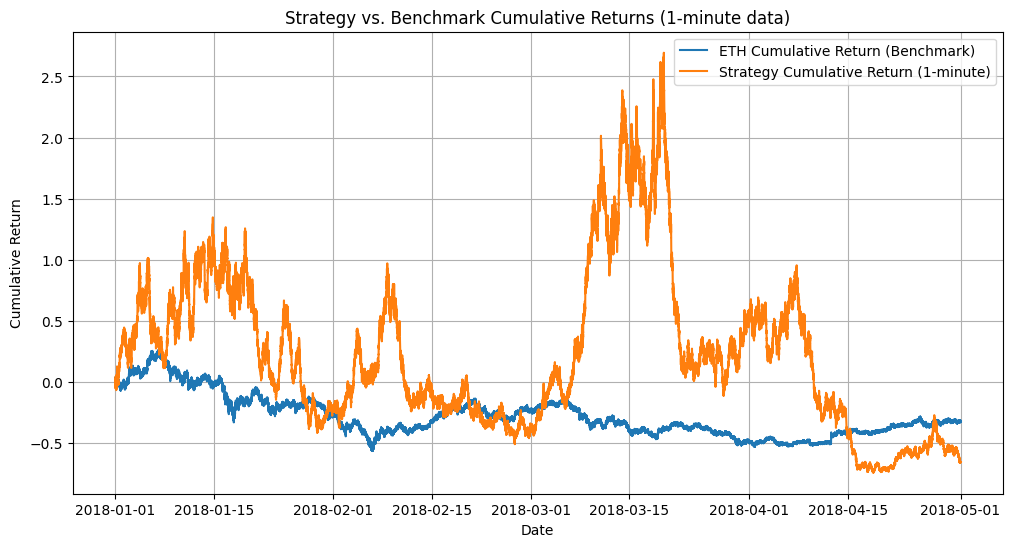

In [66]:
# 1. Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(data['ETH_cumulative_return'], label='ETH Cumulative Return (Benchmark)')
plt.plot(data['strategy_cumulative_return'], label='Strategy Cumulative Return (1-minute)')
plt.title('Strategy vs. Benchmark Cumulative Returns (1-minute data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)


# 2. Calculate performance metrics
# Total Return
total_return_strategy = data['strategy_cumulative_return'].iloc[-1]
total_return_benchmark = data['ETH_cumulative_return'].iloc[-1]

# Annualized Return (assuming 24*365 hours in a year, and our data is 1-minute)
# Adjusting for 1-minute data: 24 * 60 * 365 minutes per year
minutes_in_year = 24 * 60 * 365
annualized_return_strategy = (1 + total_return_strategy)**(minutes_in_year / len(data)) - 1
annualized_return_benchmark = (1 + total_return_benchmark)**(minutes_in_year / len(data)) - 1

# Volatility (Annualized)
# Calculate standard deviation of 1-minute returns and annualize
annualized_volatility_strategy = data['strategy_daily_return'].std() * np.sqrt(minutes_in_year)
annualized_volatility_benchmark = data['ETH_daily_return'].std() * np.sqrt(minutes_in_year)

# Sharpe Ratio (assuming risk-free rate is 0)
# Handle potential division by zero if volatility is 0
sharpe_ratio_strategy = annualized_return_strategy / annualized_volatility_strategy if annualized_volatility_strategy != 0 else np.nan
sharpe_ratio_benchmark = annualized_return_benchmark / annualized_volatility_benchmark if annualized_volatility_benchmark != 0 else np.nan


# 3. Print performance metrics
print("Performance Metrics (1-minute data):")
print(f"  Total Return (Strategy): {total_return_strategy:.4f}")
print(f"  Total Return (Benchmark): {total_return_benchmark:.4f}")
print(f"  Annualized Return (Strategy): {annualized_return_strategy:.4f}")
print(f"  Annualized Return (Benchmark): {annualized_return_benchmark:.4f}")
print(f"  Annualized Volatility (Strategy): {annualized_volatility_strategy:.4f}")
print(f"  Annualized Volatility (Benchmark): {annualized_volatility_benchmark:.4f}")
print(f"  Sharpe Ratio (Strategy): {sharpe_ratio_strategy:.4f}")
print(f"  Sharpe Ratio (Benchmark): {sharpe_ratio_benchmark:.4f}")

# 4. Display the plot
plt.show()